### Watts-Strogatz model

I had a hard time counting triangles, even in a small graph, so let's do it procedurally.

The Watts-Strogatz model shares some properties with small world properties:

- High clustering coefficient
- Short average path lengths

The algorithm:
- Start with a ring latice
- With a predetermined probability, make edges switch to new nodes

In [1]:
library("igraph", "expm");


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
# Will work so long as N/2 > connectToOnRight

createRingLatticeEdgeList = function(N, p) {
    connectToOnRight = N*(p/2);
    edgeList = matrix(NA, nrow=0, ncol=2);

    for (fromIndex in 1:N) {
        for (toDelta in 1:connectToOnRight) {
            if(fromIndex+toDelta > N) {
                toIndex = fromIndex + toDelta - N;
            } else {
                toIndex = fromIndex + toDelta;
            }
            if(toIndex < fromIndex) {
                newEdge = c(toIndex, fromIndex);
            } else {
                newEdge = c(fromIndex, toIndex);            
            }
            edgeList = rbind(edgeList, newEdge);
        }
    }
    return (edgeList)
}


In [3]:
edgeIsAvailable = function(edgeList, fromIndex, newToIndex) {
    if (fromIndex == newToIndex) {
        return (FALSE)
    }
    for(i in 1:length(edgeList[,1])) {
        if(edgeList[i,1] == fromIndex && edgeList[i,2] == newToIndex) {
            return (FALSE)
        } else if(edgeList[i,1] == newToIndex && edgeList[i,2] == fromIndex) {
            return (FALSE)
        }
    }
    return (TRUE)
}

rewireEdgeList = function(rewireProbability, edgeList, N) {
    for(i in 1:length(edgeList[,1])) {
        switchTrial = runif(n=1);
        if (switchTrial <= rewireProbability) {
            newToIndex = floor(runif(n=1, min=1, max=N+1));
            fromIndex = edgeList[i,1];
            if (edgeIsAvailable(edgeList, fromIndex, newToIndex)) {
                edgeList[i,2] = newToIndex;
            }
        }
    }
    (edgeList)
}



In [4]:
getRandomGraph = function(N, p) {
    m = matrix(rbinom(N^2, 1, p), N);
    diag(m) = 0;
    m[lower.tri(m)] = 0;
    randomGraph = graph_from_adjacency_matrix(m, mode="undirected" );
    (randomGraph)
}

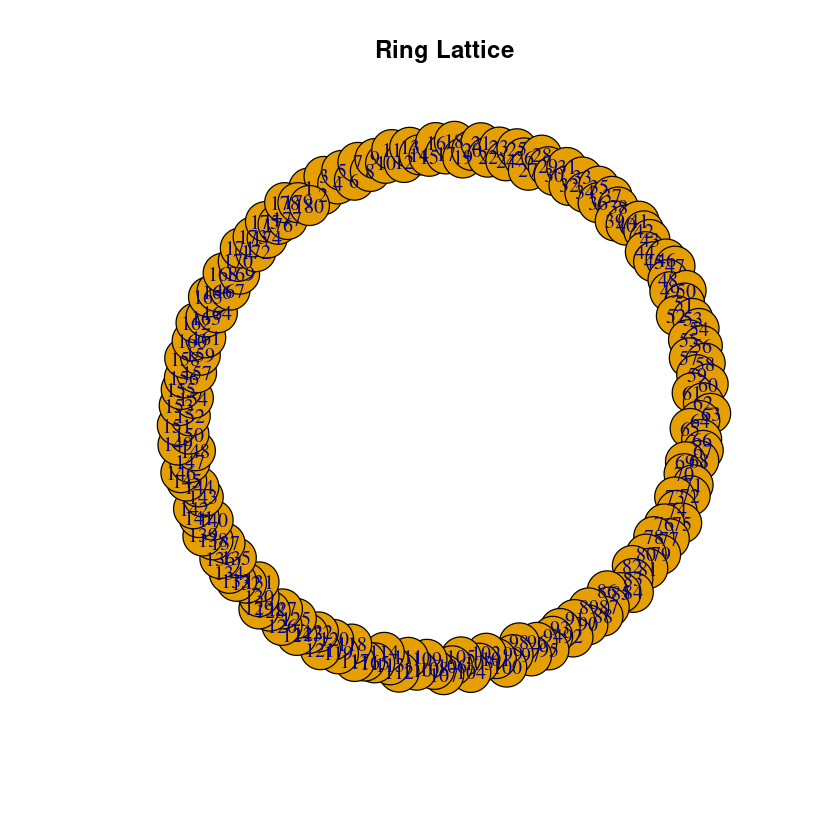

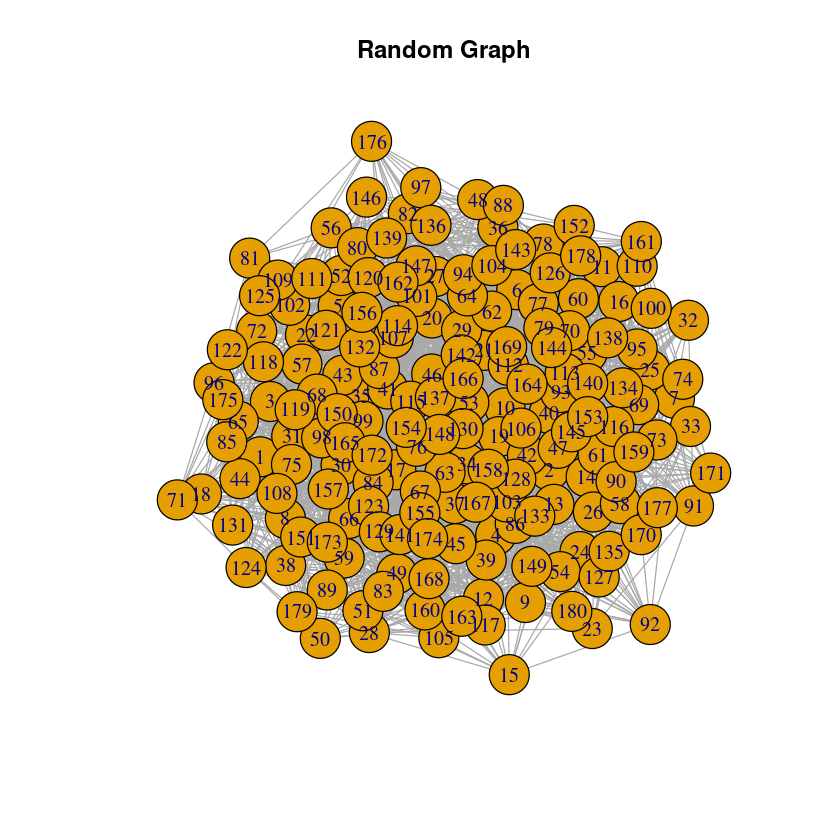

In [5]:
N = 180;
p = 0.15;

edgeList = createRingLatticeEdgeList(N, p)
ringLattice = graph_from_edgelist(edgeList, directed=FALSE);

randomGraph = getRandomGraph(N, p);

plot(ringLattice)
title("Ring Lattice")
plot(randomGraph)
title("Random Graph")


In [6]:
graphData = data.frame(rewireProbability = double(),
                       globalClusterCoefficient = double(),
                       averagePathLength = double()
                       );

for(n in 0:100) {
    rewireProbability = n/100;
    rewiredEdgeList = rewireEdgeList(rewireProbability, edgeList, N);
    rewiredRingLattice = graph_from_edgelist(rewiredEdgeList, directed=FALSE);

    graphData = rbind(graphData, list(rewireProbability=rewireProbability,
                                      globalClusterCoefficient=transitivity(rewiredRingLattice),
                                      averagePathLength=average.path.length(rewiredRingLattice)));
}

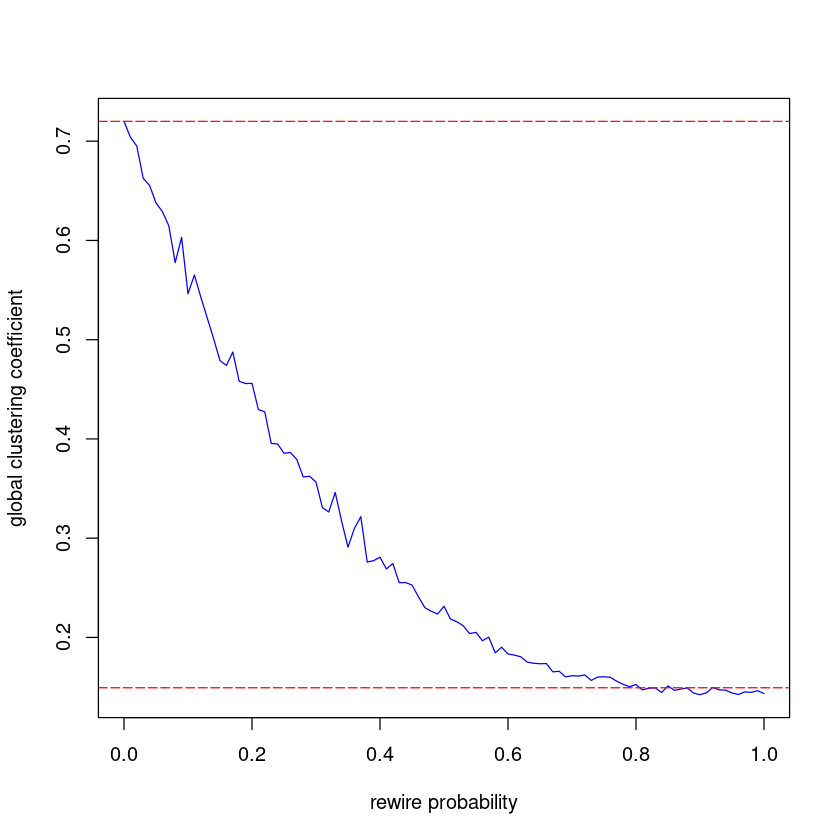

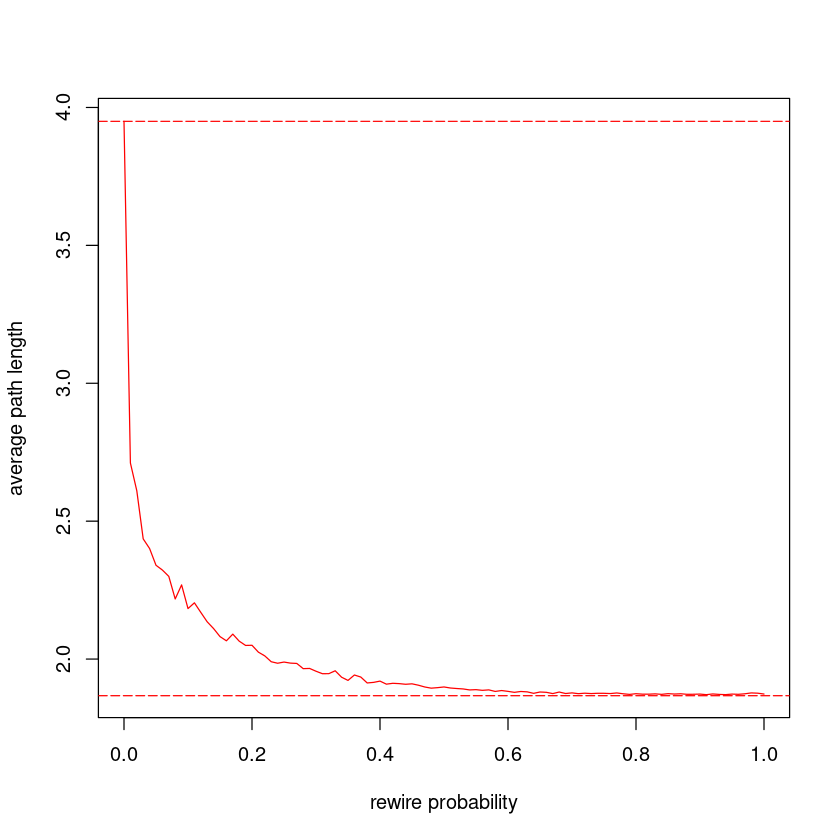

In [7]:
plot(graphData$rewireProbability,
     graphData$globalClusterCoefficient,
     type="l",
     col="blue",
     pch="o",
     xlab="rewire probability",
     ylab="global clustering coefficient",
     #ylim=c(0.1,0.8),
     lty=1);
abline(h=transitivity(ringLattice), col="red", lty=5);
abline(h=transitivity(randomGraph), col="red", lty=5);

plot(graphData$rewireProbability,
     graphData$averagePathLength,
     type="l",
     col="red",
     pch="o",
     xlab="rewire probability",
     ylab="average path length",
     #ylim=c(1.7,3.2),
     lty=1);
abline(h=average.path.length(ringLattice), col="red", lty=5);
abline(h=average.path.length(randomGraph), col="red", lty=5);



Then we can see the rewiring starts to take the form of a small world network at about $ p=0.2 $

This was expected because I had seen this Youtube video

![pic of what to expect](Screenshot_2023-08-27_13-01-24.png)

That's from here - https://www.youtube.com/watch?v=Pnh6Kg4nYbE

### The effect of average degree on average path length